##Loading the Dataset and Plotting the correlation coefficient

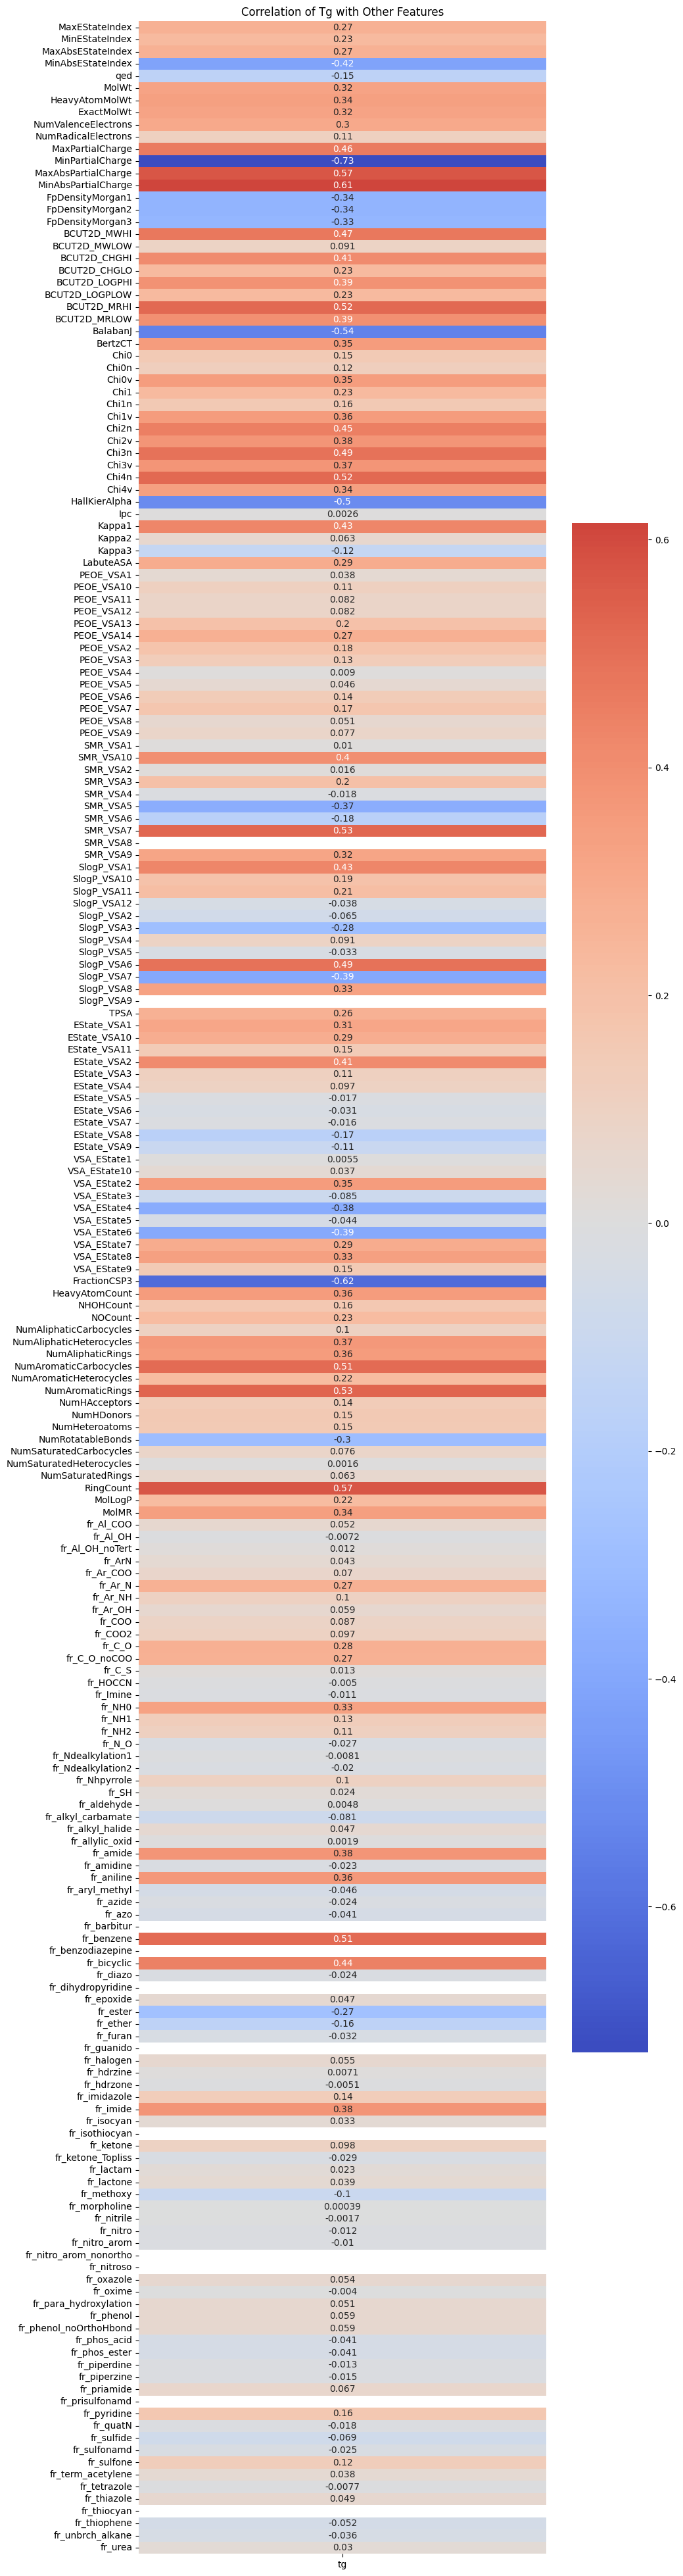

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


file_path = '/content/smiles_descriptors.csv'
data = pd.read_csv(file_path)

# Drop the non-numeric 'SMILES' column
data_numeric = data.drop(columns=['SMILES'])

# Compute the correlation matrix
correlation_matrix = data_numeric.corr()

# Extract the correlations of 'tg' with other features
tg_correlations = correlation_matrix[['tg']].drop('tg')

# Plot the heat map
plt.figure(figsize=(10, 50))
sns.heatmap(tg_correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Tg with Other Features')
plt.show()


<h2> Feature selection based on the correlation coefficient

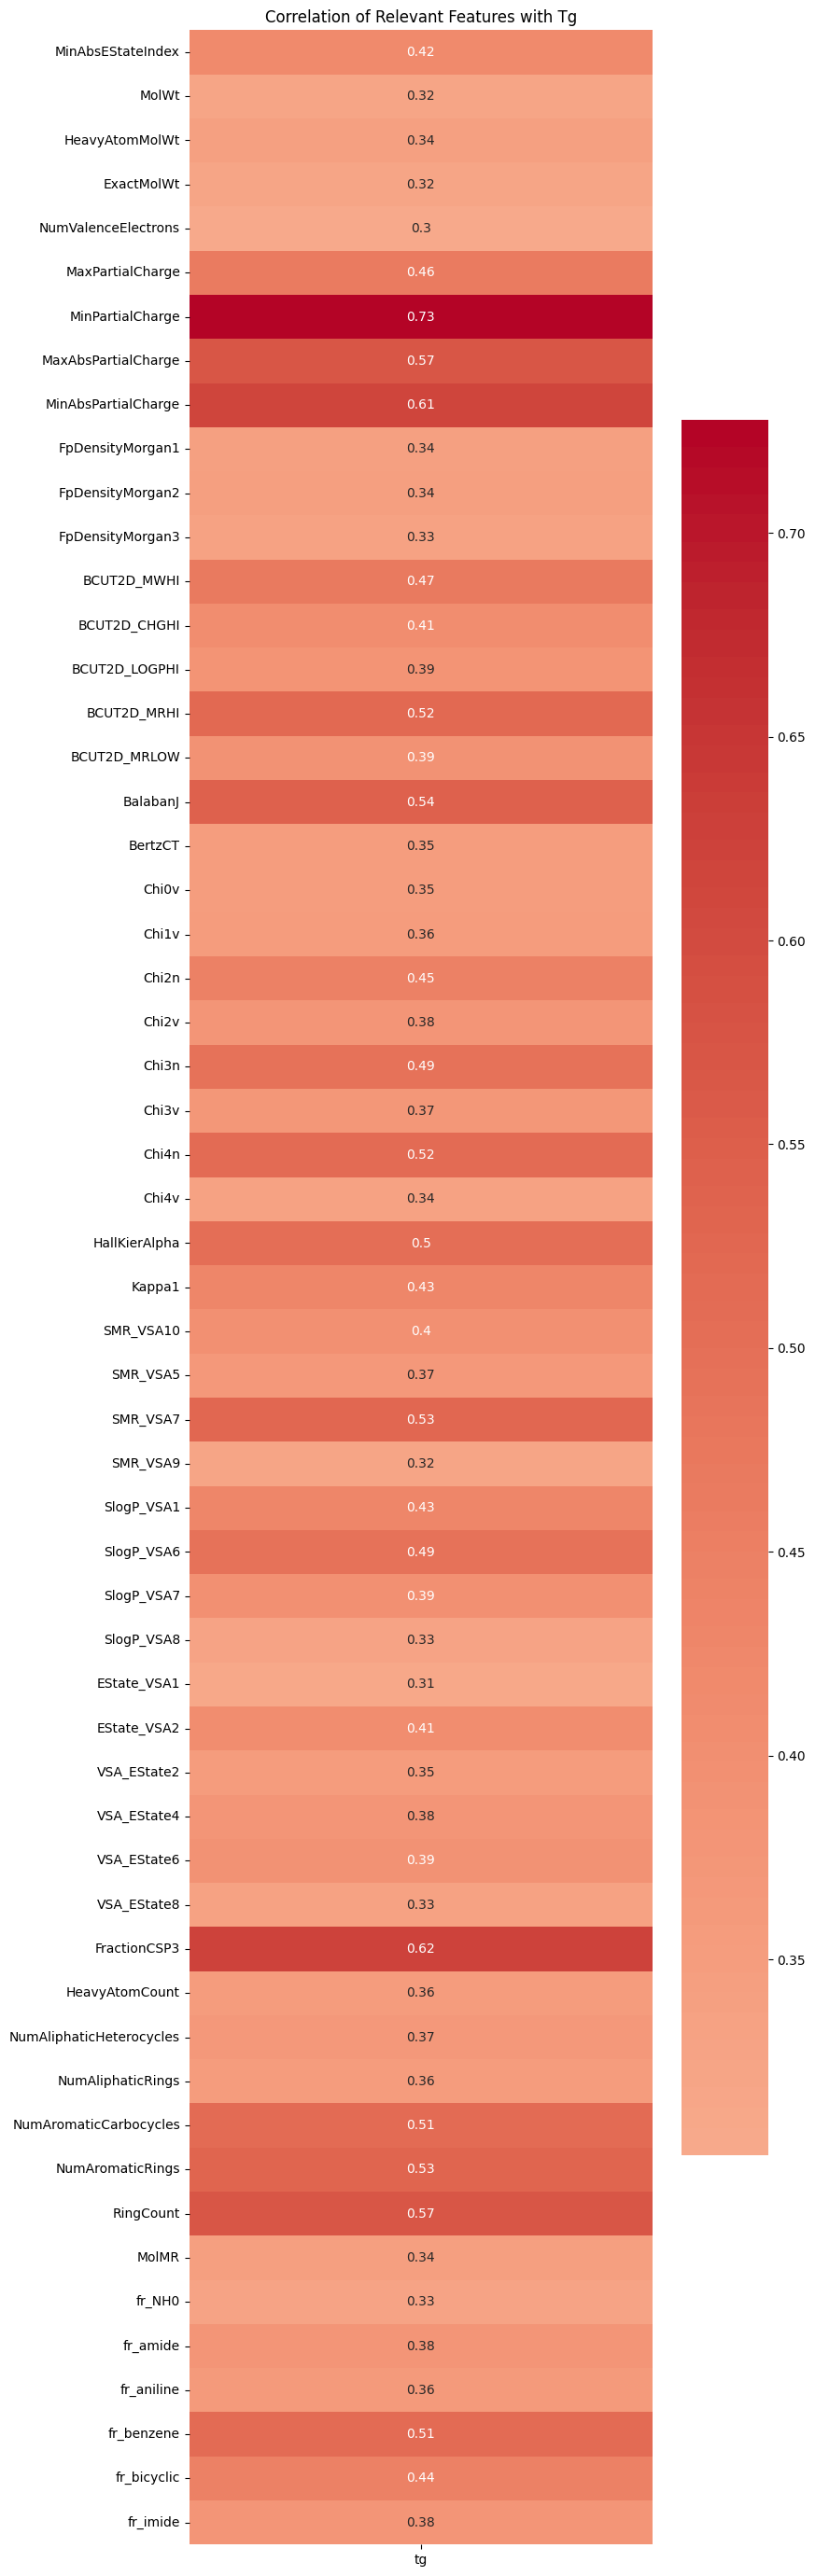

Filtered data has been saved to filtered_smiles_descriptors2.csv


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


file_path = '/content/smiles_descriptors.csv'
data = pd.read_csv(file_path)


data_numeric = data.drop(columns=['SMILES'])


correlation_matrix = data_numeric.corr()


tg_correlations = correlation_matrix['tg'].abs()

# Filter out columns with correlation less than 0.3
relevant_features = tg_correlations[tg_correlations >= 0.3].index
filtered_data = data[['SMILES'] + list(relevant_features)]


filtered_file_path = 'filtered_smiles_descriptors2.csv'
filtered_data.to_csv(filtered_file_path, index=False)


filtered_tg_correlations = tg_correlations[relevant_features].drop('tg')
plt.figure(figsize=(8, 35))
sns.heatmap(filtered_tg_correlations.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Relevant Features with Tg')
plt.show()

print(f"Filtered data has been saved to {filtered_file_path}")


<h1> Data Augmentation using the RDKit library

In [ ]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 27.1 MB/s eta 0:00:00


<h3> Adding the physical properties of the compounds

In [ ]:

import pandas as pd
from rdkit import Chem


file_path = 'filtered_smiles_final.csv'
data = pd.read_csv(file_path)


def extract_features(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        features = {}


        features['num_CH3'] = len(mol.GetSubstructMatches(Chem.MolFromSmarts('[CH3]')))
        features['num_CH2'] = len(mol.GetSubstructMatches(Chem.MolFromSmarts('[CH2]')))
        features['num_CH'] = len(mol.GetSubstructMatches(Chem.MolFromSmarts('[CH]')))
        features['num_C'] = len(mol.GetSubstructMatches(Chem.MolFromSmarts('[#6]'))) - features['num_CH3'] - features['num_CH2'] - features['num_CH']
        features['num_OH'] = len(mol.GetSubstructMatches(Chem.MolFromSmarts('[OH]')))
        features['num_COC'] = len(mol.GetSubstructMatches(Chem.MolFromSmarts('COC')))
        features['num_OC'] = len(mol.GetSubstructMatches(Chem.MolFromSmarts('C=O')))
        features['num_N'] = len(mol.GetSubstructMatches(Chem.MolFromSmarts('[N]')))
        features['num_Hal'] = len(mol.GetSubstructMatches(Chem.MolFromSmarts('[F,Cl,Br,I]')))


        features['num_double_bonds'] = sum(1 for bond in mol.GetBonds() if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE)

        return features
    except Exception as e:
        print(f"Error processing SMILES {smiles}: {e}")
        return None


feature_df = data['SMILES'].apply(extract_features).apply(pd.Series)


data_with_features = pd.concat([data, feature_df], axis=1)


output_file_path = 'merged_with_features.csv'
data_with_features.to_csv(output_file_path, index=False)


data_with_features.head()


,SMILES,tg,MinAbsEStateIndex,MolWt,HeavyAtomMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,...,num_CH3,num_CH2,num_CH,num_C,num_OH,num_COC,num_OC,num_N,num_Hal,num_double_bonds
0,C=Cc1ccccc1,367.087927,0.411111,104.152,96.088,40,0.062902,-0.098470,0.098470,0.062902,...,0,1,1,6,0,0,0,0,0,1
1,C=C(C)C(=O)OC,375.839367,1.251273,100.117,92.053,40,0.332327,-0.465675,0.465675,0.332327,...,2,1,0,2,0,1,1,0,0,2
2,O=C1CCCCCO1,253.596222,1.983565,114.144,104.064,46,0.305278,-0.465675,0.465675,0.305278,...,0,5,0,1,0,1,1,0,0,1
3,O=C1OCCOC(=O)c2ccc1cc2,346.988080,0.895255,192.170,184.106,72,0.337743,-0.458466,0.458466,0.337743,...,0,2,0,8,0,2,2,0,0,2
4,C=C,219.999698,0.740741,28.054,24.022,12,0.053156,-0.106311,0.106311,0.053156,...,0,2,0,0,0,0,0,0,0,1


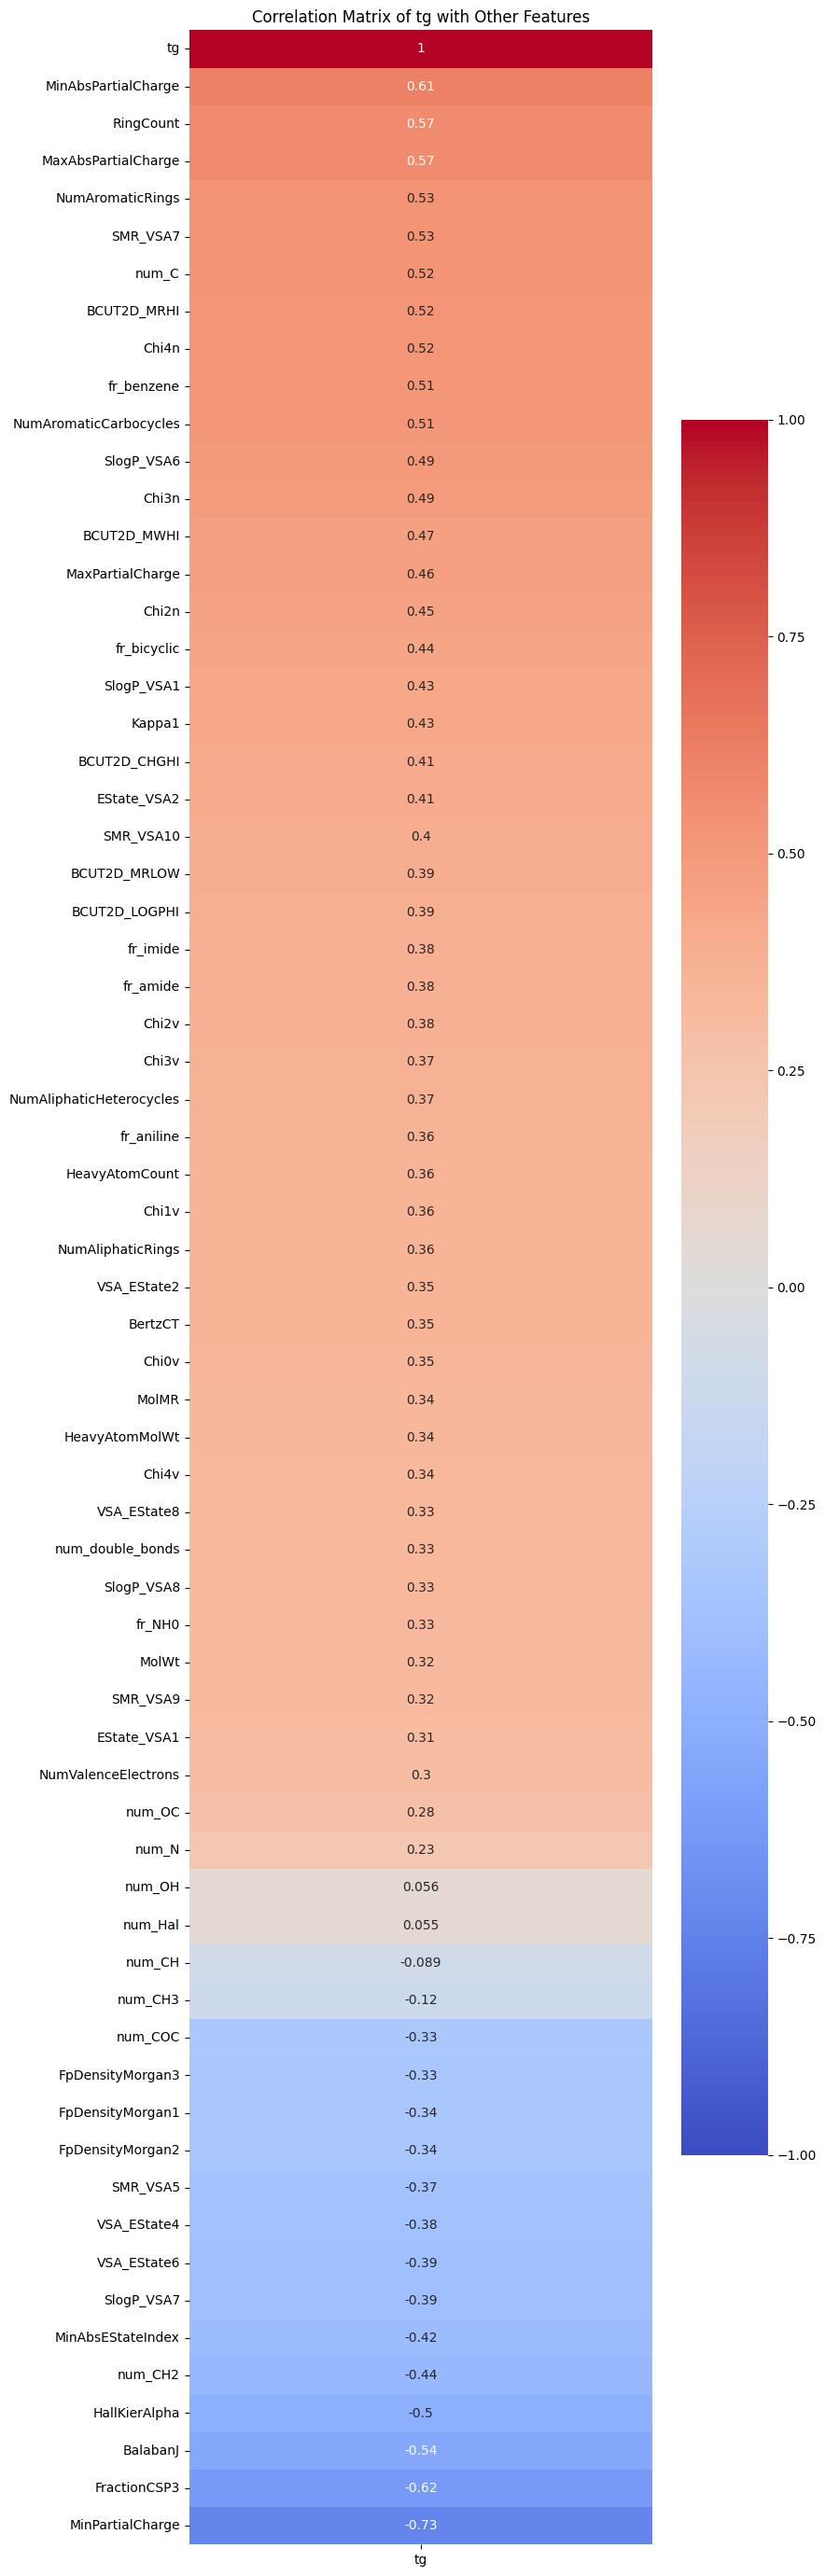

In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


file_path = 'merged_with_features.csv'
data_with_features = pd.read_csv(file_path)


correlation_matrix = data_with_features.drop(columns=['SMILES']).corr()


plt.figure(figsize=(8,35))
sns.heatmap(correlation_matrix[['tg']].sort_values(by='tg', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of tg with Other Features')
plt.show()


<h1>Lasso Regression as a Review of SINDy paper by Bruton et.al

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer


file_path = '/content/merged_with_features.csv'
data = pd.read_csv(file_path)


X = data.drop(columns=['tg', 'SMILES'])
y = data['tg']


X.replace([np.inf, -np.inf], np.nan, inplace=True)


imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Standardize the features (commented out as per the original request)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


X_train_scaled = X_train
X_test_scaled = X_test


lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)


y_pred = lasso.predict(X_test_scaled)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')


Mean Squared Error: 8579.298538420453
R² Score: 0.40397165619118514


<h2>Linear Regression, Random Forest, Gradient Boosting, XGBoost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer


file_path = '/content/filtered_smiles_final.csv'
data = pd.read_csv(file_path)


X = data.drop(columns=['tg', 'SMILES'])
y = data['tg']


X.replace([np.inf, -np.inf], np.nan, inplace=True)


imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}


def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, r2


results = {}


for name, model in models.items():
    mse, r2 = train_and_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    results[name] = {"MSE": mse, "R²": r2}


for name, metrics in results.items():
    print(f"{name} - MSE: {metrics['MSE']}, R²: {metrics['R²']}")


Linear Regression - MSE: 4554.446260368878, R²: 0.6835896257278747
Random Forest - MSE: 2336.133899175192, R²: 0.8377021136861644
Gradient Boosting - MSE: 3082.5466976202592, R²: 0.7858466872707521
XGBoost - MSE: 2262.11154402249, R²: 0.8428446578637465


<h2> Hypertuning parameters for XGBoost Model using Grid Search CV

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor


file_path = '/content/filtered_smiles_final.csv'
data = pd.read_csv(file_path)


X = data.drop(columns=['tg', 'SMILES'])
y = data['tg']


X.replace([np.inf, -np.inf], np.nan, inplace=True)


imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}


xgb = XGBRegressor(random_state=42)


grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)


grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Train a new XGBRegressor using the best parameters from the grid search
best_xgb = XGBRegressor(**best_parameters)
best_xgb.fit(X_train_scaled, y_train)

# Predict on the test set with the best model
best_predictions = best_xgb.predict(X_test_scaled)

# Calculate MSE and R² score with the best model
best_mse = mean_squared_error(y_test, best_predictions)
best_r2 = r2_score(y_test, best_predictions)

print("Best Parameters:", best_parameters)
print("Best MSE:", best_mse)
print("Best R² Score:", best_r2)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END colsamp

In [ ]:
!pip install catboost
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.0 MB/s eta 0:00:00


<h2> Ridge Regression, Adaboost and Catboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


file_path = '/content/filtered_smiles_final.csv'
data = pd.read_csv(file_path)


X = data.drop(columns=['tg', 'SMILES'])
y = data['tg']


X.replace([np.inf, -np.inf], np.nan, inplace=True)


imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


models = {
    "Ridge Regression": Ridge(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}


results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[name] = {"MSE": mse, "R²": r2}


for model_name, metrics in results.items():
    print(f"{model_name} - MSE: {metrics['MSE']}, R²: {metrics['R²']}")



Ridge Regression - MSE: 4567.626638859555, R²: 0.6826739472341854
AdaBoost - MSE: 5158.386543625654, R²: 0.6416321713769231
CatBoost - MSE: 2142.23403693634, R²: 0.8511728902580982


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network - MSE: 2701.5284005836115, R²: 0.8123171153047694
